<a href="https://colab.research.google.com/github/reyndomly/dataset-braintumor/blob/main/brain-tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Clone GitHub to access the Dataset

In [1]:
!git clone https://github.com/reyndomly/dataset-braintumor.git

Cloning into 'dataset-braintumor'...
remote: Enumerating objects: 3040, done.
remote: Total 3040 (delta 0), reused 0 (delta 0), pack-reused 3040
Receiving objects: 100% (3040/3040), 79.25 MiB | 15.31 MiB/s, done.


#Import Library

In [31]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from IPython.display import Image
import imutils   

from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from warnings import filterwarnings

import keras
import tensorflow.keras as K

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import imutils  

#Create Directories

In [3]:
#create directory for training data
os.mkdir('/content/Crop-Brain-MRI')
os.mkdir('/content/Crop-Brain-MRI/glioma_tumor')
os.mkdir('/content/Crop-Brain-MRI/meningioma_tumor')
os.mkdir('/content/Crop-Brain-MRI/pituitary_tumor')
os.mkdir('/content/Crop-Brain-MRI/no_tumor')

#create directory for testing data
os.mkdir('/content/Test-Data')
os.mkdir('/content/Test-Data/glioma_tumor')
os.mkdir('/content/Test-Data/meningioma_tumor')
os.mkdir('/content/Test-Data/pituitary_tumor')
os.mkdir('/content/Test-Data/no_tumor')

#Visualize Data

In [4]:
#specify directory
train_dir = '/content/dataset-braintumor/Brain-MRI/Training/'
test_dir = '/content/dataset-braintumor/Brain-MRI/Testing/'

In [5]:
#create classes
classes = os.listdir('/content/dataset-braintumor/Brain-MRI/Training')

In [6]:
classes

['meningioma_tumor', 'no_tumor', 'pituitary_tumor', 'glioma_tumor']

In [7]:
files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x: train_dir + c + '/' + x, os.listdir(train_dir + c)))

In [ ]:
plt.figure(figsize = (17,17))
index = 0
for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]

  for i in range(1, 5):
    index += 1
    plt.subplot(4, 4, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

In [9]:
#check the number of images in each class in the training dataset
No_images_per_class = []
Class_name = []

for i in os.listdir('/content/dataset-braintumor/Brain-MRI/Training'):
  train_class = os.listdir(os.path.join('/content/dataset-braintumor/Brain-MRI/Training', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in meningioma_tumor = 822 

Number of images in no_tumor = 395 

Number of images in pituitary_tumor = 827 

Number of images in glioma_tumor = 826 



In [ ]:
#visualize class distribution in train set
plt.figure(figsize=(8, 8))
colors = sns.color_palette('pastel')
plt.pie(No_images_per_class, 
        labels = Class_name, 
        autopct = '%1.1f%%',
        colors=colors)
plt.show()

#Data Preparation

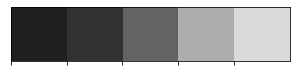

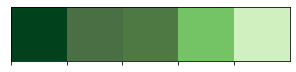

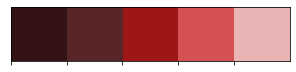

In [33]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [12]:
X_train = []
y_train = []
image_size = 240
for i in classes:
    folderPath = os.path.join('/content/dataset-braintumor/Brain-MRI','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in classes:
    folderPath = os.path.join('/content/dataset-braintumor/Brain-MRI','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 100/100 [00:00<00:00, 312.20it/s]


In [15]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [16]:
X_train.shape

(3264, 240, 240, 3)

In [19]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)

In [21]:
y_train_new = []
for i in y_train:
    y_train_new.append(classes.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(classes.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

#Model Achitect

In [22]:
#build the model
effnet = EfficientNetB1(weights='imagenet', 
                        include_top=False, 
                        input_shape=(image_size, image_size, 3))

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs=effnet.input, 
              outputs=model)

#get summary()
model.summary()

27033600/27018416 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 240, 240, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 240, 240, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D

#Compile

In [25]:
#compile model
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
#tensorboard
tensorboard = TensorBoard(log_dir = 'logs')

#define checkpoint
checkpoint = ModelCheckpoint('model.h5', 
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)

#early stopping
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          mode='auto',
                          verbose=1)

#reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.3, 
                              patience = 2, 
                              min_delta = 0.001,
                              mode='auto',
                              verbose=1)

#Train the Model

In [36]:
#train the model
history = model.fit(X_train,
                    y_train,
                    validation_split=0.1,
                    epochs=12,
                    verbose=1,
                    batch_size=32,
                    callbacks=[tensorboard,checkpoint, earlystop, reduce_lr])

Epoch 1/12
74/74 [==============================] - ETA: 0s - loss: 0.1111 - accuracy: 0.9681 
Epoch 1: val_accuracy did not improve from 0.91603
74/74 [==============================] - 1293s 17s/step - loss: 0.1111 - accuracy: 0.9681 - val_loss: 0.5157 - val_accuracy: 0.8473 - lr: 0.0010
Epoch 2/12
74/74 [==============================] - ETA: 0s - loss: 0.0853 - accuracy: 0.9715 
Epoch 2: val_accuracy improved from 0.91603 to 0.96183, saving model to model.h5
74/74 [==============================] - 1235s 17s/step - loss: 0.0853 - accuracy: 0.9715 - val_loss: 0.1836 - val_accuracy: 0.9618 - lr: 0.0010
Epoch 3/12
74/74 [==============================] - ETA: 0s - loss: 0.0759 - accuracy: 0.9762 
Epoch 3: val_accuracy did not improve from 0.96183
74/74 [==============================] - 1217s 16s/step - loss: 0.0759 - accuracy: 0.9762 - val_loss: 0.2932 - val_accuracy: 0.9389 - lr: 0.0010
Epoch 4/12
74/74 [==============================] - ETA: 0s - loss: 0.0612 - accuracy: 0.9817 
Ep

In [1]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

NameError: ignored